### Importing Modules 

In [145]:
import numpy as np
import pandas as pd 
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import linear_model
import statsmodels.api as sm
warnings.filterwarnings('ignore')

## Accessing Data Sources

### Connect to Local SQL IMDB

In [146]:
conn = sqlite3.connect("data/im.db")
imdb_people = pd.read_sql( 
    """
    SELECT persons.primary_name, movie_basics.primary_title, characters, category, principals.job 
        FROM principals 
            JOIN persons
                ON principals.person_id == persons.person_id
            JOIN movie_basics 
                ON principals.movie_id == movie_basics.movie_id
            JOIN movie_ratings
                ON principals.movie_id == movie_ratings.movie_id
    """
, conn)

#standardize column names
imdb_people = imdb_people.rename(columns={"primary_title": "title", "start_year": "year"})

In [147]:
imdb_movies = pd.read_sql( 
    """
    SELECT movie_basics.start_year, movie_basics.primary_title, movie_ratings.averagerating, genres 
        FROM movie_basics 
            JOIN movie_ratings
                ON movie_basics.movie_id == movie_ratings.movie_id
    """
, conn)

imdb_movies = imdb_movies.rename(columns={"primary_title": "title", "start_year": "year", "averagerating": 'imdb_rating'})
imdb_movies['genres'] = imdb_movies['genres'].str.replace("Musical", "Music")
imdb_movies['genres'] = imdb_movies['genres'].str.replace("Sci-Fi", "Science Fiction")

### CSV and TSV Imports

In [148]:
#https://www.boxofficemojo.com/
bom = pd.read_csv('data/bom.movie_gross.csv')
#https://www.themoviedb.org/
tmdb = pd.read_csv('data/tmdb.movies.csv')
#https://www.the-numbers.com/
tn_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv')
#Academy_Awards_DB_from_https://www.kaggle.com/datasets/unanimad/the-oscar-award
oscars = pd.read_csv('data/the_oscar_award.csv')

## Data Cleaning

We making sure each DataFrame is using a datetimes for dates and cleaning any 'unique' systems, like TMDB using a numeric code for genre. We also standardize column names. 

### Cleaning Functions

In [149]:
def csStringToList(cs_string):
    if type(cs_string) == str:
        return cs_string.split(',')
    else:
        return cs_string
    
def money_to_int(money):
    if type(money) != str:
        return money
    if '$' in money:
        #remove cash symbol
        money = money.replace('$', '')
    money = money.replace(',', '')
    money.strip()
    return money

def move_standardize(movie):
    if type(movie) == str:
        movie = movie.replace("â", "'")
        return movie
    else: 
        return movie

Make sure the IMDB dfs are also using lists of genres.

In [150]:
imdb_movies['genres'] = imdb_movies['genres'].map(csStringToList)

imdb_movies['title'] = imdb_movies['title'].map(move_standardize)
imdb_people['title'] = imdb_people['title'].map(move_standardize)

### Clean BOM

In [151]:
bom = bom.rename(columns={"foreign_gross": "worldwide_gross"})
bom['domestic_gross'] = bom['domestic_gross'].map(money_to_int).astype(float)
bom['worldwide_gross'] = bom['worldwide_gross'].map(money_to_int).astype(float)
bom['title'] = bom['title'].map(move_standardize)
bom['worldwide_gross'] =  bom['worldwide_gross'] + bom['domestic_gross']

### Clean TMDB

In [152]:
def genreIDtoGenre(id_list):
    #'comma separated' 
    cs = id_list[1:-1]
    cs.strip()
    ids = cs.split(', ')
    newlist = []
    for id in ids:
        if id == "12":
            newlist.append("Adventure")
        if id == "28":
            newlist.append("Action")
        if id == "16":
            newlist.append("Animation")
        if id == "35":
            newlist.append("Comedy")
        if id == "80":
            newlist.append("Crime")
        if id == "99":
            newlist.append("Documentary")
        if id == "18":
            newlist.append("Drama")
        if id == "10751":
            newlist.append("Family")
        if id == "14":
            newlist.append("Fantasy")
        if id == "36":
            newlist.append("History")
        if id == "27":
            newlist.append("Horror")
        if id == "10402":
            newlist.append("Music")
        if id == "9648":
            newlist.append("Mystery")
        if id == "10749":
            newlist.append("Romance")
        if id == "878":
            newlist.append("Science Fiction")
        if id == "10770":
            newlist.append("TV Movie")
        if id == "53":
            newlist.append("Thriller")
        if id == "10752":
            newlist.append("War")
        if id == "37":
            newlist.append("Western")
    return newlist

tmdb['genres'] = tmdb['genre_ids'].map(genreIDtoGenre)
tmdb['release_date'] = pd.to_datetime(tmdb['release_date'])
tmdb['title'] = tmdb['title'].map(move_standardize)

tmdb = tmdb.rename(columns={"vote_average": "tmdb_rating"})
tmdb = tmdb.drop(columns={"id", "genre_ids",  'Unnamed: 0'})

### Clean TN

In [153]:
def checkUSD(money):
    money = money[0]
    if money =='$':
        return True
    else:
        return False

tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])
tn_movie_budgets['production_budget'] = tn_movie_budgets['production_budget'].map(money_to_int)
tn_movie_budgets['worldwide_gross'] = tn_movie_budgets['worldwide_gross'].map(money_to_int)
tn_movie_budgets['domestic_gross'] = tn_movie_budgets['domestic_gross'].map(money_to_int)
tn_movie_budgets['year'] = tn_movie_budgets['release_date'].dt.year
tn_movie_budgets['movie'] = tn_movie_budgets['movie'].map(move_standardize)

tn_movie_budgets = tn_movie_budgets.rename(columns={"movie": "title"})

### Oscar Data Cleaning and Organization

In [154]:
# Removing rows without a film name
oscars = oscars[oscars['film'].notna()]
oscars['film'] = oscars['film'].map(move_standardize)

In [155]:
#Importing a map to change awards from specific award to Major or Minor Award
oscar_categ_map = pd.read_csv('data/oscar_categ_map.csv')

In [156]:
#Creating Lists of Major and Minor Award Categories to map against the Oscar Award dataframe
major_oscars = oscar_categ_map['Major'].to_list()
minor_oscars = oscar_categ_map['Minor'].to_list()

In [157]:
def categ_major_oscar(category):
    if category in major_oscars:
        return 1
    else:
        return 0

def categ_minor_oscar(category):
    if category in major_oscars:
        return 0
    else:
        return 1

oscars['nominations'] = 1
oscars['Major_Noms'] = oscars['category'].map(categ_major_oscar)
oscars['Minor_Noms'] = oscars['category'].map(categ_minor_oscar)

In [158]:
oscars['Major_Win'] = 0
oscars['Minor_Win'] = 0

for index, row in oscars.iterrows():
    if row['winner'] == True:
        if row['Minor_Noms'] == 1:
            oscars.at[index, 'Minor_Win'] = 1
        else:
            oscars.at[index, 'Major_Win'] = 1

In [159]:
oscars = oscars.groupby(['film', 'year_film']).sum().reset_index()
oscars = oscars.rename(columns={'film': 'title', 'year_film': 'year'})
oscars_by_film = oscars.groupby(['title', 'year']).sum().reset_index()

## Merging Data Sources

### Financial Data

We first merge bom and tn_movie budgets, as they are our main sources of financial data.

In [160]:
budget_info = pd.concat([tn_movie_budgets, bom]) # 7,926 rows
budget_info['production_budget'] = budget_info['production_budget'].fillna(value=0)
budget_info['domestic_gross'] = budget_info['domestic_gross'].fillna(value=0)
budget_info['worldwide_gross'] = budget_info['worldwide_gross'].fillna(value=0)

budget_info['production_budget'] = budget_info['production_budget'].astype(float)
budget_info['domestic_gross'] = budget_info['domestic_gross'].astype(float)
budget_info['worldwide_gross'] = budget_info['worldwide_gross'].astype(float)

def profit_ratio(row):
    if row['production_budget'] == 0:
        return 0
    else:
        return (row['worldwide_gross'] - row['production_budget']) / row['production_budget'] * 100

budget_info['financial_ratio'] = budget_info.apply(profit_ratio, axis = 1)

#drop duplicates
budget_info = budget_info.drop_duplicates(["title", "year"])

budget_info = budget_info.drop(columns='id')

### Movie Ratings
We then want to merge IMBD and TMDB, which have more information on ratings.

In [161]:
#joining TMDB and IMDB on the title and year
tmdb_imdb = pd.concat([imdb_movies, tmdb]) # 95,483 rows
#drop duplicates
tmdb_imdb = tmdb_imdb.drop_duplicates(["title", "release_date"])

### Combining Financial Info (BOM and TN) with Movie Information (IMDB and TMDB)

In [162]:
movie_db = budget_info.merge(tmdb_imdb, how='left', on=['title', 'release_date']) # 7,926 rows

#drop duplicates

movie_db['year_x'] = movie_db['year_x'].fillna(pd.to_datetime(movie_db['year_y']))

#drop duplicate columns 
movie_db = movie_db.drop(columns={"year_y"})
movie_db = movie_db.rename(columns={"year_x": "year"})

### Creating a Dataframe with Oscars, Financial and Movie

Merge our oscar data into our main movie dataframe and fill missing values with zero. 

In [163]:
movies_oscars = movie_db.merge(oscars, how='left', on=['title', 'year']) # 7,926 rows
movies_oscars = movies_oscars.drop(columns=['year_ceremony', 'ceremony'])
movies_oscars['nominations'] = movies_oscars['nominations'].fillna(0)
movies_oscars['name'] = movies_oscars['name'].fillna(0)
movies_oscars['winner'] = movies_oscars['winner'].fillna(0)
movies_oscars['Major_Noms'] = movies_oscars['Major_Noms'].fillna(0)
movies_oscars['Minor_Noms'] = movies_oscars['Minor_Noms'].fillna(0)
movies_oscars['Major_Win'] = movies_oscars['Major_Win'].fillna(0)
movies_oscars['Minor_Win'] = movies_oscars['Minor_Win'].fillna(0)
movies_oscars['Total_Wins'] = movies_oscars['Major_Win'] + movies_oscars['Minor_Win']

### Create Feature to Average Audience Ratings

If a movie has a rating from one source and not the other, take the rating that exists. If it has both, take the average.

In [164]:
# Function to calculate average rating
def calculate_avg_rating(row):
    if pd.isna(row['imdb_rating']) and pd.isna(row['tmdb_rating']):
        return np.nan
    elif pd.isna(row['imdb_rating']):
        return row['tmdb_rating']
    elif pd.isna(row['tmdb_rating']):
        return row['imdb_rating']
    else:
        return (row['imdb_rating'] + row['tmdb_rating']) / 2

# Apply the function to each row
movies_oscars['avg_rating'] = movies_oscars.apply(calculate_avg_rating, axis=1)
#drop old ratings
movies_oscars = movies_oscars.drop(columns=['imdb_rating', 'tmdb_rating'])

### Final clean to reduce dataset by removing rows with no financials and create another dataframe where all rows have audience ratings and reduce the max budget to $10MM, and by genres of interest.

In [169]:
movies_db = movies_oscars.loc[(movies_oscars['worldwide_gross'] != 0) & (movies_oscars['production_budget'] != 0)]

In [170]:
max_budget = 10000000
max_ratio = 75000 
movies_budget = movies_db.loc[(movies_db['production_budget'] <= max_budget)]
movies_db_rating = movies_budget.loc[movies_budget['avg_rating'].notnull()]

## Individuals with Oscars
Merge IMDB People with Oscar, Financial and Movie Data to examine the people within our production budget range.

In [239]:
movies_oscars_amp_mh = imdb_people.merge(movies_budget, how='left', on='title') 
movies_oscars_amp_mh = movies_oscars_amp_mh.loc[movies_oscars_amp_mh['nominations'].notna()]

Sum how many nominations and wins each person is assosiated with. 

In [268]:
movies_sum = movies_oscars_amp_mh.groupby(['primary_name']).sum(numeric_only=True).sort_values('Total_Wins', ascending=False)
movies_sum = movies_sum.drop(columns = ['production_budget', 'domestic_gross', 'worldwide_gross', 'year', 'financial_ratio',  'popularity', 'vote_count', 'avg_rating'])

Get the mean for their projects

In [244]:
movies_mean = movies_oscars_amp_mh.groupby(['primary_name']).mean(numeric_only=True)
movies_mean = movies_mean.drop(columns = ['vote_count','winner', 'Major_Noms', 'Minor_Noms', 'nominations', 'Major_Win', 'Minor_Win', 'Total_Wins'])

Use a dataframe to display their sums in a tidy way.

In [261]:
actor_perf = movies_sum.merge(movies_mean, on='primary_name') # 27,572 rows

In [265]:
actor_winners = actor_perf.loc[actor_perf['Total_Wins']> 2]
actor_winners = actor_winners.sort_values(by= ['financial_ratio', 'Total_Wins'], ascending=False)

,winner,nominations,Major_Noms,Minor_Noms,Major_Win,Minor_Win,Total_Wins,production_budget,domestic_gross,worldwide_gross,year,financial_ratio,popularity,avg_rating
primary_name,,,,,,,,,,,,,,
Mahesh Desai,3.0,10.0,3.0,7.0,2.0,1.0,3.0,1000000.0,117235147.0,225000000.0,1976.0,22400.000000,NaN,NaN
Mimoh Chakraborty,3.0,10.0,3.0,7.0,2.0,1.0,3.0,1000000.0,117235147.0,225000000.0,1976.0,22400.000000,NaN,NaN
Syed Jaan Ahmed,3.0,10.0,3.0,7.0,2.0,1.0,3.0,1000000.0,117235147.0,225000000.0,1976.0,22400.000000,NaN,NaN
Nishpal Singh,3.0,10.0,3.0,7.0,2.0,1.0,3.0,1000000.0,117235147.0,225000000.0,1976.0,22400.000000,NaN,NaN
Nitin Shilkar,3.0,10.0,3.0,7.0,2.0,1.0,3.0,1000000.0,117235147.0,225000000.0,1976.0,22400.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Shaun J. Brown,5.0,10.0,4.0,6.0,1.0,4.0,5.0,5200000.0,2000000.0,2000000.0,1944.0,-61.538462,NaN,NaN
Martín Espina,5.0,10.0,4.0,6.0,1.0,4.0,5.0,5200000.0,2000000.0,2000000.0,1944.0,-61.538462,NaN,NaN
James Robert Miller,5.0,10.0,4.0,6.0,1.0,4.0,5.0,5200000.0,2000000.0,2000000.0,1944.0,-61.538462,NaN,NaN


### Data Visualization

The first set of plots is a visual assessment of how production budget impacts gross revenue and financial ratio, which is a feature that is equal to the the profit or loss divided by the production budget.

All Films


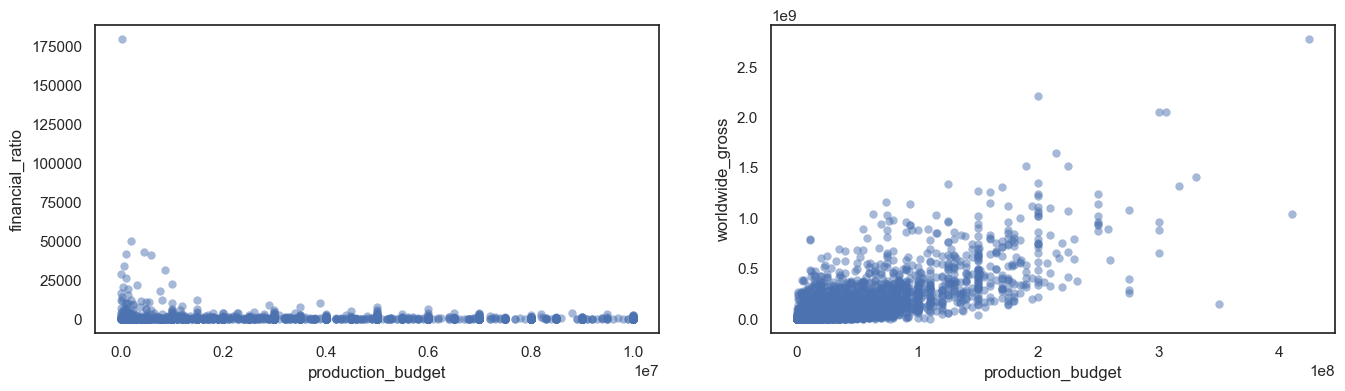

In [171]:
fig, ax = plt.subplots(figsize=(16, 4), nrows=1, ncols=2)
sns.set_style("white")
sns.color_palette("hls", 8)

sns.scatterplot(x='production_budget', y='financial_ratio', data=movies_budget, alpha=0.5, ax = ax[0],linewidth=0)
sns.scatterplot(x='production_budget', y='worldwide_gross', data=movies_db, alpha=0.5, ax = ax[1],linewidth=0)
print("All Films")

Production Budget < $10MM


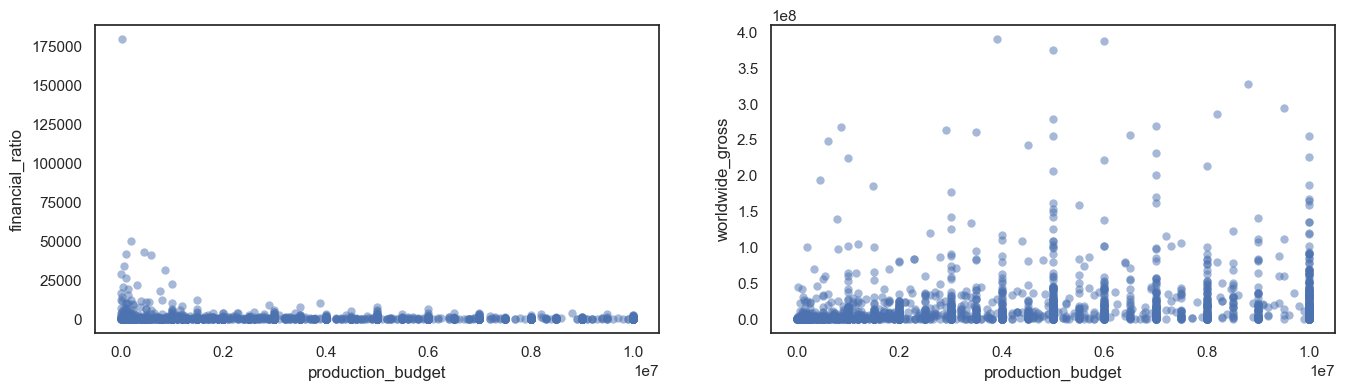

In [172]:
fig, ax = plt.subplots(figsize=(16, 4), nrows=1, ncols=2)
sns.set_style("white")
sns.color_palette("hls", 8)

sns.scatterplot(x='production_budget', y='financial_ratio', data=movies_budget, alpha=0.5, ax = ax[0],linewidth=0)
sns.scatterplot(x='production_budget', y='worldwide_gross', data=movies_budget, alpha=0.5, ax = ax[1],linewidth=0);
print("Production Budget < $10MM")

### Visualization to assess the impact of winning oscars has on budget and gross revenue.

All Films


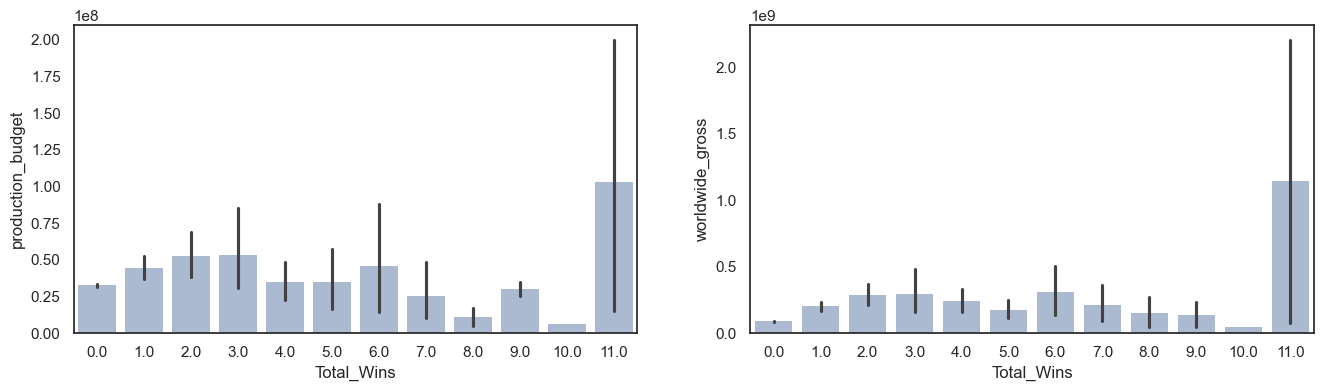

In [173]:
fig, ax = plt.subplots(figsize=(16, 4), nrows=1, ncols=2)
sns.set_style("white")
sns.color_palette("hls", 8)

sns.barplot(x='Total_Wins', y='production_budget', data=movies_db, alpha=0.5, ax = ax[0],linewidth=0) 
sns.barplot(x='Total_Wins', y='worldwide_gross', data=movies_db, alpha=0.5, ax = ax[1],linewidth=0)
print("All Films")

Production Budget < $10MM


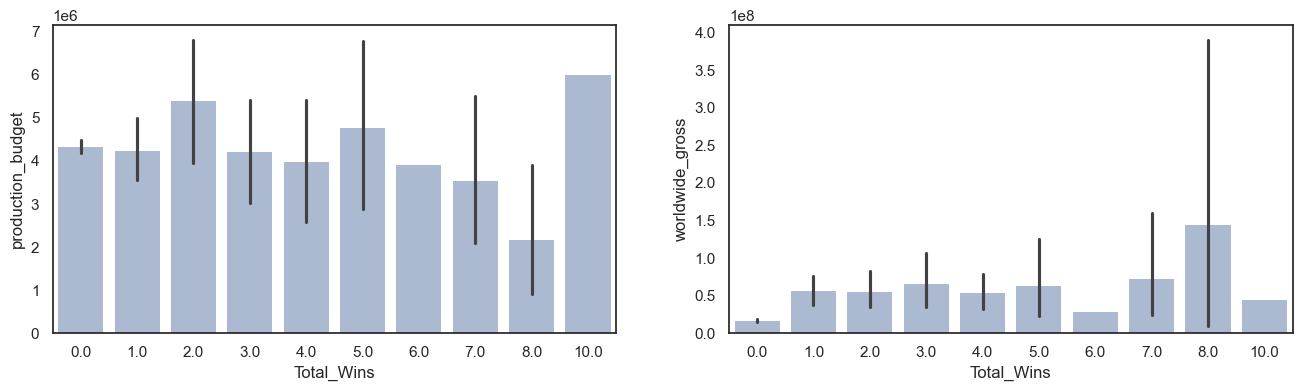

In [174]:
fig, ax = plt.subplots(figsize=(16, 4), nrows=1, ncols=2)
sns.set_style("white")
sns.color_palette("hls", 8)

sns.barplot(x='Total_Wins', y='production_budget', data=movies_budget, alpha=0.5, ax = ax[0],linewidth=0) 
sns.barplot(x='Total_Wins', y='worldwide_gross', data=movies_budget, alpha=0.5, ax = ax[1],linewidth=0);
print("Production Budget < $10MM")

### Assessment of how Profits Vary with Respect to Genre

In [218]:
movie_genres = movies_budget.explode('genres')
movie_genres = movie_genres.drop(columns={"release_date", "title", "year", "studio", "category", "name", "original_language", "original_title"})
movie_genres = movie_genres.groupby(movie_genres['genres'])

Text(0, 0.5, 'profit (in 10s of millions)')

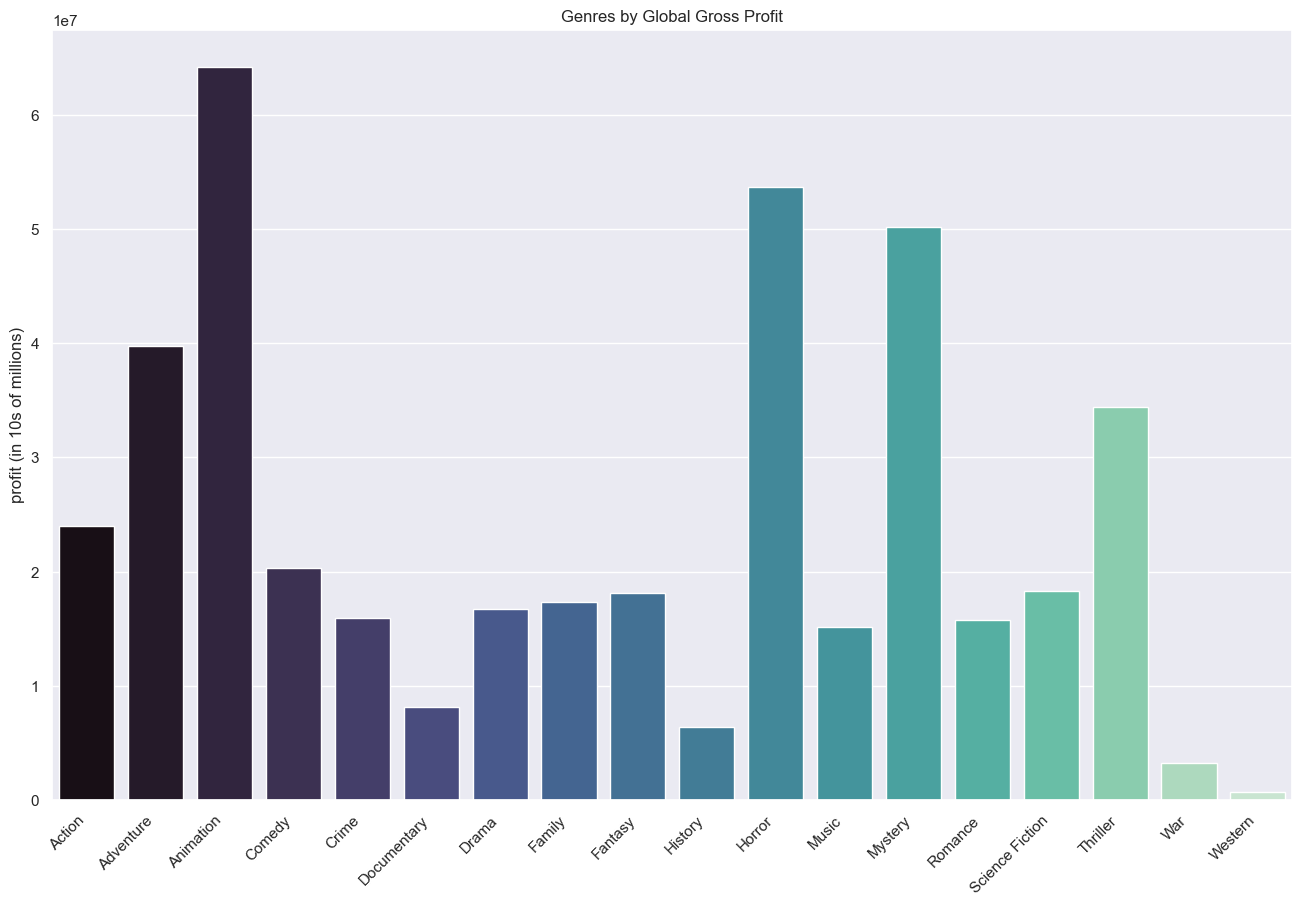

In [203]:
sns.set_theme()

#accidents per year
fig, ax = plt.subplots(figsize=(16, 10))

genres = [genre for genre, df in movie_genres]
x = genres

worldwide_gross = movie_genres['worldwide_gross']
y = list(worldwide_gross.mean().values)

genre_plot = sns.barplot(x=x, y=y, palette="mako")
genre_plot.set_xticklabels(genre_plot.get_xticklabels(), rotation=45, ha="right")
ax.set_title('Genres by Global Gross Profit')
ax.set_ylabel("profit (in 10s of millions)")

Text(0, 0.5, 'Profit Margin')

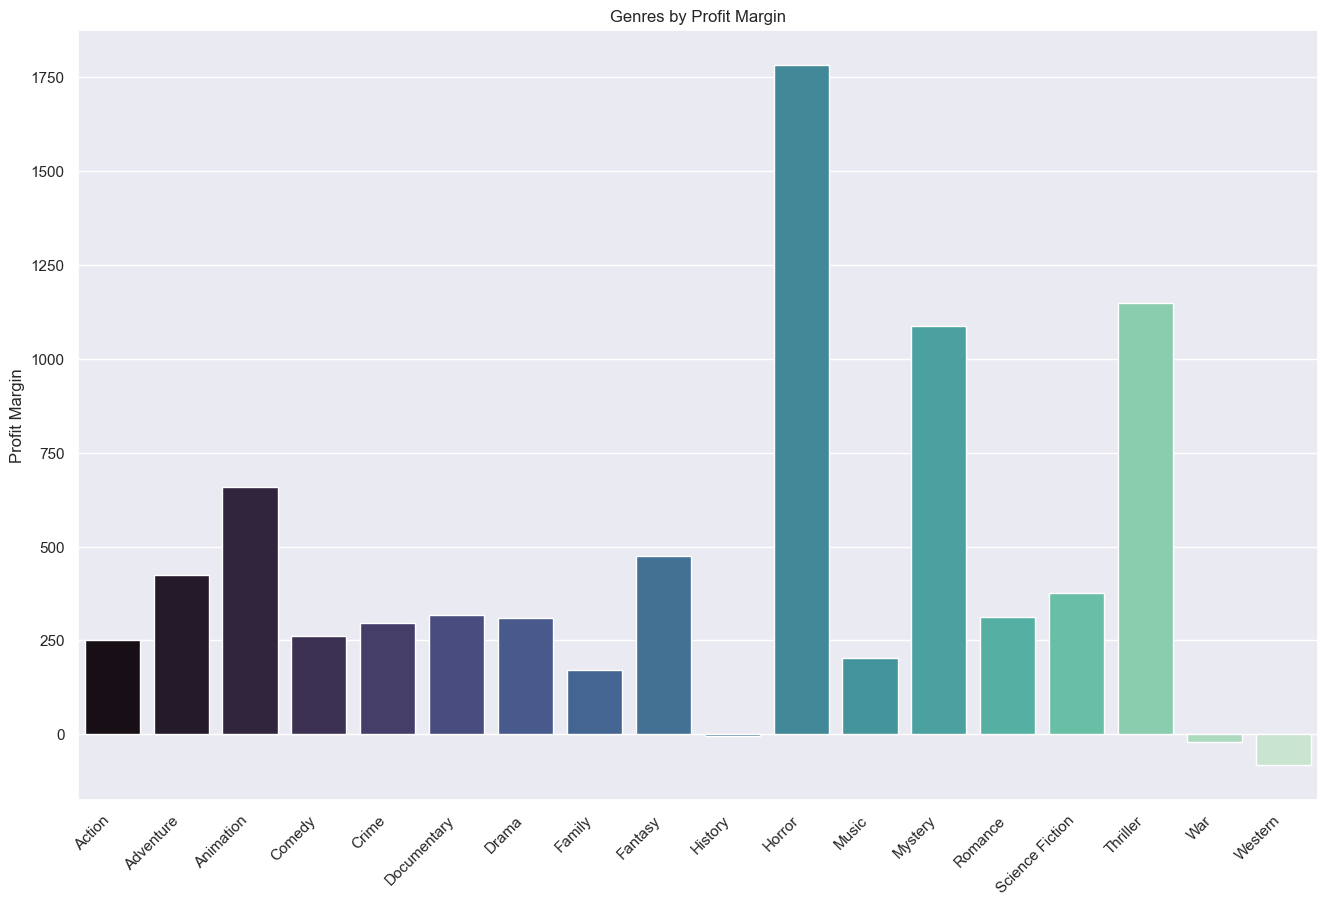

In [208]:
sns.set_theme()

#accidents per year
fig, ax = plt.subplots(figsize=(16, 10))

worldwide_gross = movie_genres['financial_ratio']
y = list(worldwide_gross.mean().values)

genre_plot = sns.barplot(x=x, y=y, palette="mako")
genre_plot.set_xticklabels(genre_plot.get_xticklabels(), rotation=45, ha="right")
ax.set_title('Genres by Profit Margin')
ax.set_ylabel("Profit Margin")

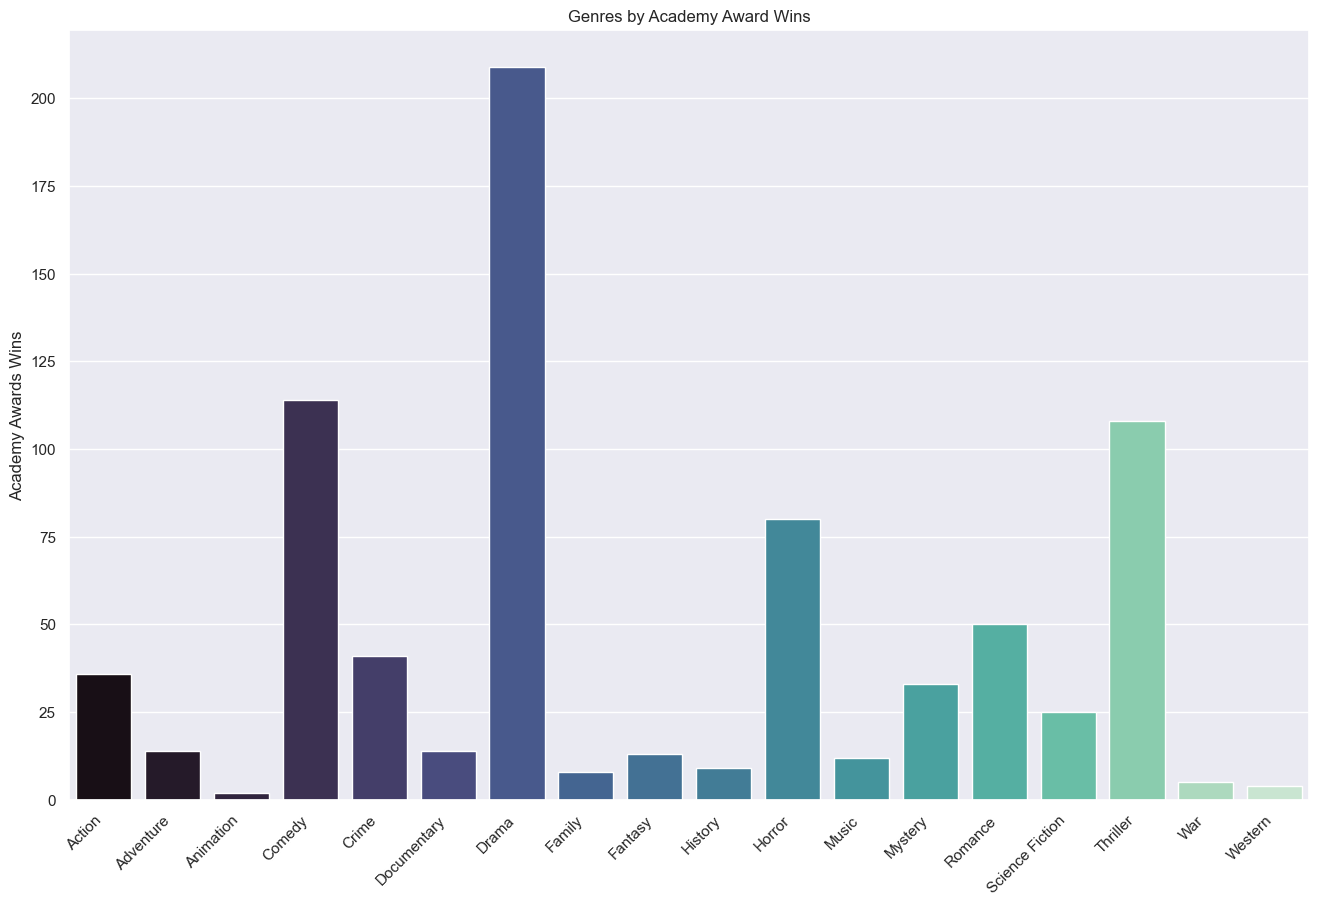

In [206]:
sns.set_theme()

#accidents per year
fig, ax = plt.subplots(figsize=(16, 10))

genres = [genre for genre, df in movie_genres]
x = genres

Total_Wins = movie_genres['Total_Wins']
y = list(Total_Wins.count().values)

genre_plot = sns.barplot(x=x, y=y, palette="mako")
genre_plot.set_xticklabels(genre_plot.get_xticklabels(), rotation=45, ha="right")
ax.set_title('Genres by Academy Award Wins')
ax.set_ylabel("Academy Awards Wins");

### Assessment of how audience rating impacts revenue and profits

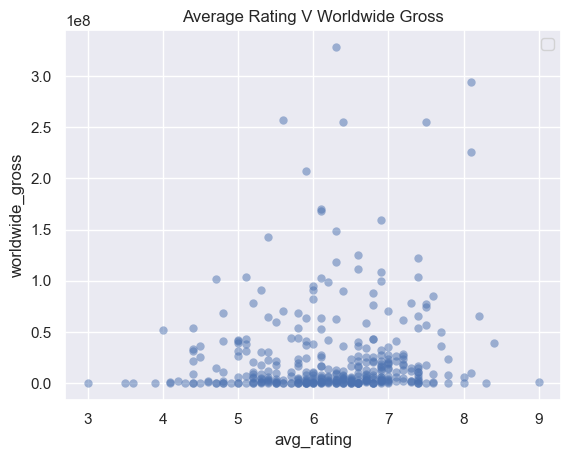

In [179]:
fig, ax = plt.subplots()
sns.set_theme()

Profit_V_Budget = pd.DataFrame(
    {
        'avg_rating': movies_budget['avg_rating'],
        'worldwide_gross': movies_budget['worldwide_gross']
    }
)
sns.scatterplot(x='avg_rating', y='worldwide_gross', data=Profit_V_Budget, alpha=0.5, linewidth=0)
ax.set_title('Average Rating V Worldwide Gross')
ax.legend();

Text(0.5, 1.0, 'Average Budget VS Profit Ratio')

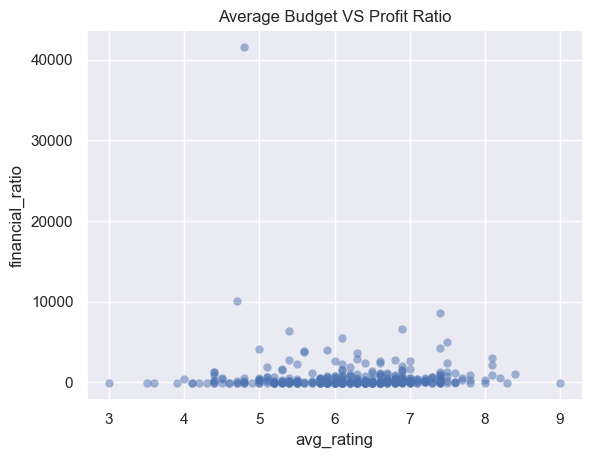

In [180]:
fig, ax = plt.subplots()
sns.set_theme()

Profit_V_Budget = pd.DataFrame(
    {
        'avg_rating': movies_budget['avg_rating'],
        'financial_ratio': movies_budget['financial_ratio']
    }
)
sns.scatterplot(x='avg_rating', y='financial_ratio', data=Profit_V_Budget, alpha=0.5, linewidth=0)
ax.set_title('Average Budget VS Profit Ratio')

# Regressions

## Visualize our data 

In [181]:
movies_budget['production_budget'].value_counts().sort_index()

production_budget
1100.0          1
5000.0          1
6000.0          1
7000.0          4
9000.0          1
             ... 
9600000.0       1
9700000.0       1
9800000.0       1
9900000.0       2
10000000.0    206
Name: count, Length: 227, dtype: int64

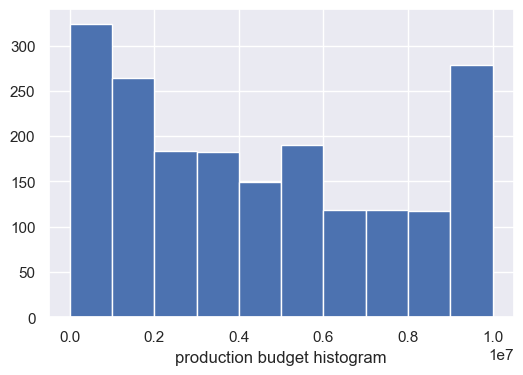

In [182]:
fig, ax = plt.subplots(figsize = (6,4))

ax.hist(movies_budget['production_budget'], bins = 10, range=[0, 10000000])
plt.xlabel('production budget histogram')
plt.show()

In [183]:
movies_budget['worldwide_gross'].value_counts().sort_index()

worldwide_gross
26.0           1
176.0          1
401.0          1
423.0          1
450.0          1
              ..
294654618.0    1
328203506.0    1
374890034.0    1
387510179.0    1
390525192.0    1
Name: count, Length: 1886, dtype: int64

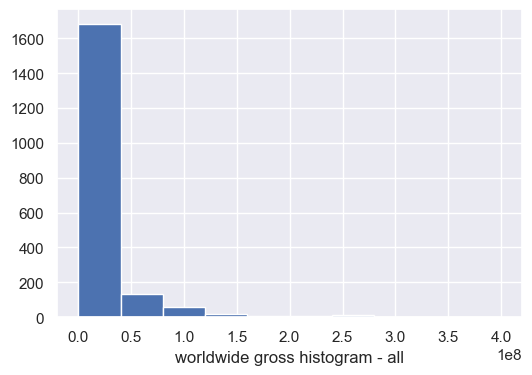

''

In [184]:
fig, ax = plt.subplots(figsize = (6,4))

ax.hist(movies_budget['worldwide_gross'], bins = 10, range=[0, 4e8])
plt.xlabel('worldwide gross histogram - all')
plt.show()
;

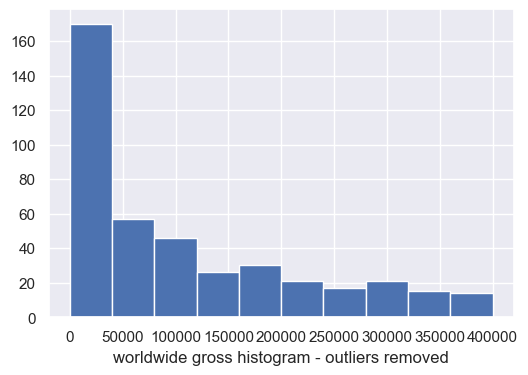

''

In [185]:
fig, ax = plt.subplots(figsize = (6,4))

ax.hist(movies_budget['worldwide_gross'], bins = 10, range=[0, 4e5])
plt.xlabel('worldwide gross histogram - outliers removed')
plt.show()
;

In [186]:
movies_budget['financial_ratio'].value_counts().sort_index()

financial_ratio
-99.997400        1
-99.987455        1
-99.986200        1
-99.980723        1
-99.975078        1
                 ..
 41283.333333     1
 41556.474000     1
 43051.785333     1
 49775.000000     1
 179900.000000    1
Name: count, Length: 1916, dtype: int64

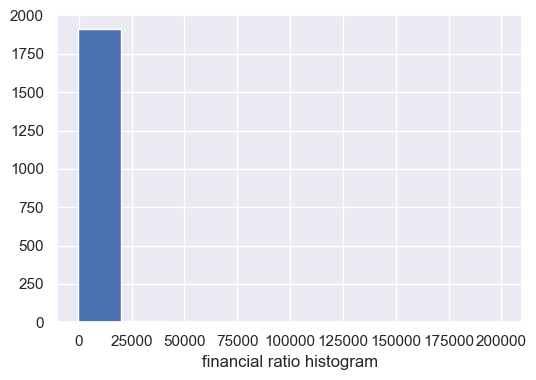

''

In [187]:
fig, ax = plt.subplots(figsize = (6,4))

ax.hist(movies_budget['financial_ratio'], bins = 10, range=[-200, 199800])
plt.xlabel('financial ratio histogram')
plt.show()
;

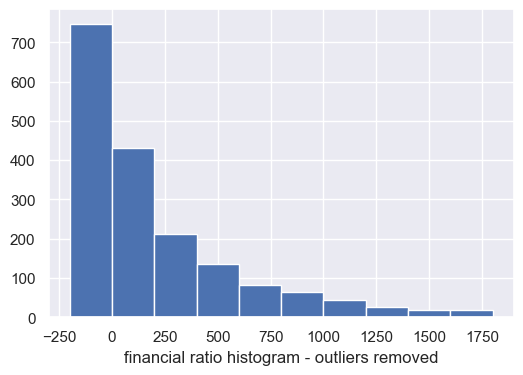

''

In [188]:
fig, ax = plt.subplots(figsize = (6,4))

ax.hist(movies_budget['financial_ratio'], bins = 10, range=[-200, 1800])
plt.xlabel('financial ratio histogram - outliers removed')
plt.show()
;

In [189]:
movies_budget['nominations'].value_counts().sort_index()

nominations
0.0     1674
1.0       96
2.0       45
3.0       20
4.0       18
5.0       15
6.0       11
7.0       10
8.0       15
9.0        4
10.0       7
11.0       5
12.0       2
13.0       3
Name: count, dtype: int64

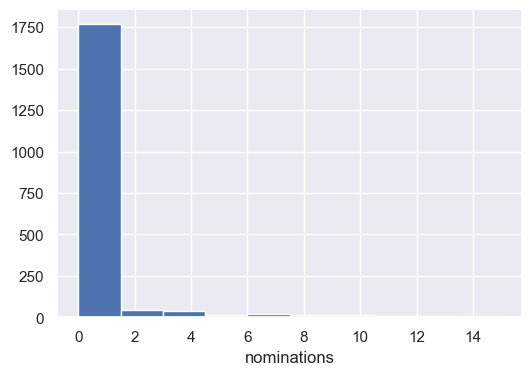

''

In [190]:
fig, ax = plt.subplots(figsize = (6,4))

ax.hist(movies_budget['nominations'], bins = 10, range=[0, 15])
plt.xlabel('nominations')
plt.show()
;

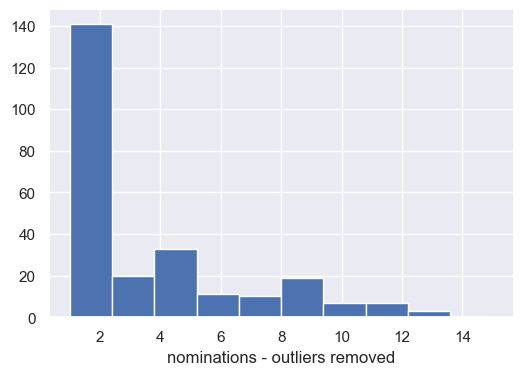

''

In [191]:
fig, ax = plt.subplots(figsize = (6,4))

ax.hist(movies_budget['nominations'], bins = 10, range=[1, 15])
plt.xlabel('nominations - outliers removed')
plt.show()
;

In [192]:
movies_budget['Total_Wins'].value_counts().sort_index()

Total_Wins
0.0     1818
1.0       47
2.0       16
3.0       16
4.0       11
5.0        9
6.0        1
7.0        3
8.0        3
10.0       1
Name: count, dtype: int64

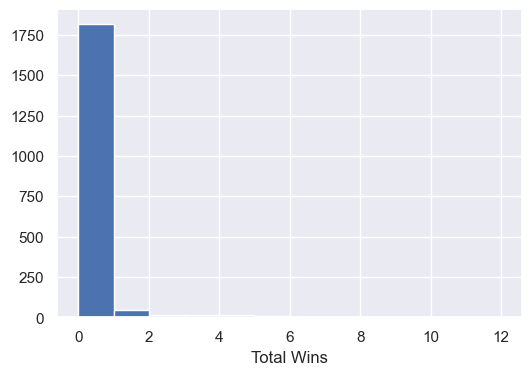

''

In [193]:
fig, ax = plt.subplots(figsize = (6,4))

ax.hist(movies_budget['Total_Wins'], bins = 12, range=[0, 12])
plt.xlabel('Total Wins')
plt.show()
;

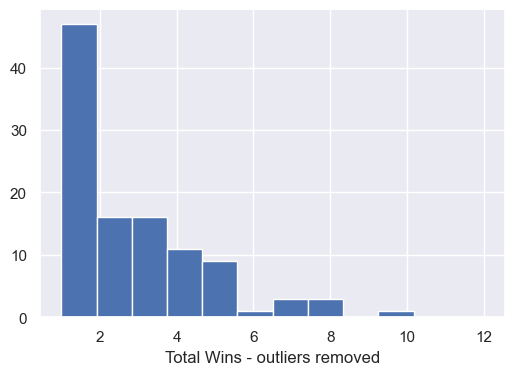

''

In [194]:
fig, ax = plt.subplots(figsize = (6,4))

ax.hist(movies_budget['Total_Wins'], bins = 12, range=[1, 12])
plt.xlabel('Total Wins - outliers removed')
plt.show()
;

In [195]:
movies_budget['avg_rating'].value_counts().sort_index()

avg_rating
3.0     1
3.5     1
3.6     1
3.9     1
4.0     1
4.1     2
4.2     1
4.3     1
4.4     7
4.5     3
4.6     2
4.7     4
4.8     6
4.9     1
5.0     8
5.1     6
5.2     9
5.3    10
5.4    11
5.5    10
5.6     5
5.7     5
5.8    13
5.9    16
6.0    14
6.1    19
6.2    10
6.3    15
6.4    14
6.5    13
6.6    17
6.7    15
6.8    15
6.9    21
7.0    15
7.1     6
7.2     9
7.3     6
7.4    15
7.5     6
7.6     4
7.7     2
7.8     3
8.0     2
8.1     3
8.2     1
8.3     1
8.4     1
9.0     1
Name: count, dtype: int64

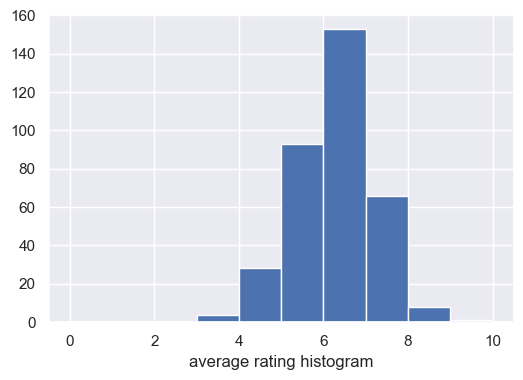

''

In [196]:
fig, ax = plt.subplots(figsize = (6,4))

ax.hist(movies_budget['avg_rating'], bins = 10, range=[0, 10])
plt.xlabel('average rating histogram')
plt.show()
;

## Regressions of Profit and Budget

Is there a correlation between the budget, oscar nominations, oscar wins, and the worldwide gross?

In [197]:
x = movies_budget[['production_budget', 'nominations', 'Total_Wins']]
y = movies_budget['worldwide_gross']

x = sm.add_constant(x)
gross_regr = sm.OLS(y, x).fit()
gross_regr_pred = gross_regr.predict(x)
summary = gross_regr.summary()

print(summary)

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     99.15
Date:                Fri, 13 Sep 2024   Prob (F-statistic):           1.14e-59
Time:                        09:05:53   Log-Likelihood:                -36215.
No. Observations:                1925   AIC:                         7.244e+04
Df Residuals:                    1921   BIC:                         7.246e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4.686e+06   1.38e+0

Is there a correlation between the budget and the worldwide gross?

In [198]:
x = movies_budget['production_budget']
y = movies_budget['worldwide_gross']

x = sm.add_constant(x)
gross_regr = sm.OLS(y, x).fit()
gross_regr_pred = gross_regr.predict(x)
summary = gross_regr.summary()

print(summary)

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     94.63
Date:                Fri, 13 Sep 2024   Prob (F-statistic):           7.27e-22
Time:                        09:05:54   Log-Likelihood:                -36308.
No. Observations:                1925   AIC:                         7.262e+04
Df Residuals:                    1923   BIC:                         7.263e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               7.77e+06   1.43e+0

Is there a correlation between the budget, oscar nominations, oscar wins, and the profit relative to budget spent?

In [199]:
x = movies_budget[['production_budget', 'nominations', 'Total_Wins']]
y = movies_budget['financial_ratio']

x = sm.add_constant(x)
gross_regr = sm.OLS(y, x).fit()
gross_regr_pred = gross_regr.predict(x)
summary = gross_regr.summary()

print(summary)

                            OLS Regression Results                            
Dep. Variable:        financial_ratio   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     12.42
Date:                Fri, 13 Sep 2024   Prob (F-statistic):           4.79e-08
Time:                        09:05:54   Log-Likelihood:                -19131.
No. Observations:                1925   AIC:                         3.827e+04
Df Residuals:                    1921   BIC:                         3.829e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1594.8239    193.58

Is there a correlation between the rating and the worldwide gross?

In [200]:
x = movies_db_rating['avg_rating']
y = movies_db_rating['worldwide_gross']

x = sm.add_constant(x)
gross_regr = sm.OLS(y, x).fit()
gross_regr_pred = gross_regr.predict(x)
summary = gross_regr.summary()

print(summary)

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.077
Date:                Fri, 13 Sep 2024   Prob (F-statistic):             0.0442
Time:                        09:05:54   Log-Likelihood:                -6726.4
No. Observations:                 353   AIC:                         1.346e+04
Df Residuals:                     351   BIC:                         1.346e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.199e+06   1.64e+07     -0.440      0.6

Is there a correlation between the rating and the profit relative to budget spent?

In [201]:
x = movies_db_rating['avg_rating']
y = movies_db_rating['financial_ratio']

x = sm.add_constant(x)
gross_regr = sm.OLS(y, x).fit()
gross_regr_pred = gross_regr.predict(x)
summary = gross_regr.summary()

print(summary)

                            OLS Regression Results                            
Dep. Variable:        financial_ratio   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6975
Date:                Fri, 13 Sep 2024   Prob (F-statistic):              0.404
Time:                        09:05:54   Log-Likelihood:                -3258.9
No. Observations:                 353   AIC:                             6522.
Df Residuals:                     351   BIC:                             6530.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1356.1570    887.201      1.529      0.1

# Regression over Genre

In [223]:
divided_genres = movies_budget.explode('genres')
divided_genres = divided_genres.drop(columns={"release_date", "title", "year", "studio", "category", "name", "original_language", "original_title"})

horror = divided_genres.loc[divided_genres['genres'] == "Horror"]
thriller = divided_genres.loc[divided_genres['genres'] == "Thriller"]

### Horror

In [227]:
x = horror['production_budget']
y = horror['worldwide_gross']

x = sm.add_constant(x)
gross_regr = sm.OLS(y, x).fit()
gross_regr_pred = gross_regr.predict(x)
summary = gross_regr.summary()

print(summary)

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     13.74
Date:                Fri, 13 Sep 2024   Prob (F-statistic):           0.000391
Time:                        09:41:47   Log-Likelihood:                -1542.0
No. Observations:                  80   AIC:                             3088.
Df Residuals:                      78   BIC:                             3093.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.669e+07   1.19e+0

In [228]:
x = horror['production_budget']
y = horror['financial_ratio']

x = sm.add_constant(x)
gross_regr = sm.OLS(y, x).fit()
gross_regr_pred = gross_regr.predict(x)
summary = gross_regr.summary()

print(summary)

                            OLS Regression Results                            
Dep. Variable:        financial_ratio   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     4.817
Date:                Fri, 13 Sep 2024   Prob (F-statistic):             0.0312
Time:                        09:41:48   Log-Likelihood:                -790.53
No. Observations:                  80   AIC:                             1585.
Df Residuals:                      78   BIC:                             1590.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3607.7520    989.45

## Thriller

In [226]:
x = thriller['production_budget']
y = thriller['financial_ratio']

x = sm.add_constant(x)
gross_regr = sm.OLS(y, x).fit()
gross_regr_pred = gross_regr.predict(x)
summary = gross_regr.summary()

print(summary)

                            OLS Regression Results                            
Dep. Variable:        financial_ratio   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     4.885
Date:                Fri, 13 Sep 2024   Prob (F-statistic):             0.0292
Time:                        09:40:06   Log-Likelihood:                -1051.8
No. Observations:                 108   AIC:                             2108.
Df Residuals:                     106   BIC:                             2113.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2557.9818    752.26

In [237]:
x = movies_oscars[['nominations']]
y = movies_oscars['production_budget']

x = sm.add_constant(x)
gross_regr = sm.OLS(y, x).fit()
gross_regr_pred = gross_regr.predict(x)
summary = gross_regr.summary()

print(summary)

                            OLS Regression Results                            
Dep. Variable:      production_budget   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     135.4
Date:                Fri, 13 Sep 2024   Prob (F-statistic):           4.85e-31
Time:                        09:59:53   Log-Likelihood:            -1.4959e+05
No. Observations:                7926   AIC:                         2.992e+05
Df Residuals:                    7924   BIC:                         2.992e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.168e+07   4.43e+05     48.944      

# Appendix

Future Features: a Weighted Measure of Film Quality

In [202]:
weighted_ratings = movies_oscars.loc[movies_oscars['category'].notnull()]
weighted_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1002 entries, 0 to 7829
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       938 non-null    datetime64[ns]
 1   title              1002 non-null   object        
 2   production_budget  1002 non-null   float64       
 3   domestic_gross     1002 non-null   float64       
 4   worldwide_gross    1002 non-null   float64       
 5   year               1002 non-null   int64         
 6   studio             63 non-null     object        
 7   financial_ratio    1002 non-null   float64       
 8   genres             261 non-null    object        
 9   original_language  205 non-null    object        
 10  original_title     205 non-null    object        
 11  popularity         205 non-null    float64       
 12  vote_count         205 non-null    float64       
 13  category           1002 non-null   object        
 14  name         